![](New-to-Homebrew-Large.jpg)

In [1]:
# TODO Standarizálás, model építés, összefüggés keresés, del átírása drop column-ra, Lowercase, használni a stringet is
#Ujrairni a kodot, megszepiteni
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 30)

In [2]:
recipes = pd.read_csv('input/recipeData.csv', encoding = "ISO-8859-1")

|Column|Description|
|-|-|
|BeerID| Record ID|
|Name| Beer Name|
|URL| Location of recipe webpage at https|//www.brewersfriend.com|
|Style| Type of brew|
|StyleID| Numeric ID for type of brew|
|Size(L)| Amount brewed for recipe listed|
|OG| Specific gravity of wort before fermentation|
|FG| Specific gravity of wort after fermentation|
|ABV| Alcohol By Volume|
|IBU| International Bittering Units|
|Color| Standard Reference Method - light to dark ex. 40 = black|
|BoilSize| Fluid at beginning of boil|
|BoilTime| Time wort is boiled|
|BoilGravity| Specific gravity of wort before the boil|
|Efficiency| Beer mash extraction efficiency - extracting sugars from the grain during mash|
|MashThickness| Amount of water per pound of grain|
|SugarScale| Scale to determine the concentration of dissolved solids in wort|
|BrewMethod| Various techniques for brewing|
|PitchRate| Yeast added to the fermentor per gravity unit - M cells/ml/deg P|
|PrimaryTemp| Temperature at the fermenting stage|
|PrimingMethod| N|
|PrimingAmount| Amount of priming sugar used|
|UserId| User ID|

1. rész: Adatok előkészítése

In [3]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73861 entries, 0 to 73860
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     73861 non-null  int64  
 1   BeerID         73861 non-null  int64  
 2   Name           73860 non-null  object 
 3   URL            73861 non-null  object 
 4   Style          73265 non-null  object 
 5   StyleID        73861 non-null  int64  
 6   Size(L)        73861 non-null  float64
 7   OG             73861 non-null  float64
 8   FG             73861 non-null  float64
 9   ABV            73861 non-null  float64
 10  IBU            73861 non-null  float64
 11  Color          73861 non-null  float64
 12  BoilSize       73861 non-null  float64
 13  BoilTime       73861 non-null  int64  
 14  BoilGravity    70871 non-null  float64
 15  Efficiency     73861 non-null  float64
 16  MashThickness  43997 non-null  float64
 17  SugarScale     73861 non-null  object 
 18  BrewMe

In [4]:
#Szűkítjük a szavak halmazát
recipes['Name'] = recipes['Name'].str.lower()

#Kitrötöljük azt az egy elemet, amelyhez nem tartozik név
recipes = recipes[recipes['Name'].notna()]

#Létrehozunk egy szótárat, amiben eltároljuk, melyik szó hányszor fordul elő
frequency_dict = {}

#Kiszámoljuk, hogy melyik szó hányszor fordul elő
names = recipes["Name"]
for text in names:
    words = text.split()
    for word in words:
        if word in frequency_dict:
            frequency_dict[word] += 1
        else:
            frequency_dict[word] = 0
            
#Azokat, melyek nem utalnak sörkategóriára kiszedjük
wrong_words = ["-", "the", "in","is","/", "on", "i", "&", "a", "of", "you", "1", "2", "3",
              "i","ii", "de", "de", "and", "2015","5","2016", "2017", "#1", "to","recipe","awesome", "beer",
              "not","#", "by", "w/", "no", "50", "my", "#2", "20", "25", "x", "no.", "c", "g", "...",
              "4", "7", "it", "el", "10", "#3"]

for w in wrong_words:
    frequency_dict[w] = 0
    
#Kicseréljük a neveket a leggyakrabban előforduló szóval bennük
most_frequent_words = []
for text in names:
    words = text.split()
    searched = ""
    max_frequency = -1
    for word in words:
        if frequency_dict[word] > max_frequency:
            searched = word
            max_frequency = frequency_dict[word]
            
    #Ha kevesebb, mint 100 van belőle, azt írjuk, hogy Unknown
    if max_frequency < 100:
        searched = 'unknown'
    most_frequent_words.append(searched)

#Visszaírjuk
recipes['Name'] = most_frequent_words

In [5]:
#len(recipes['Name'].unique())

Töröljük azokat a sorokat, melyeket nem fogunk használni

In [6]:
#Töröljük azokat az oszlopokat, amelyeknek kevesebb, mint a tizede van kitöltve
recipes.dropna(axis = 1, thresh = int(recipes.shape[0] / 10), inplace = True)

#Töröljük azokat az oszlopokat, amik nem hordoznak információt
#A nevet lehetne használni, ha valamilyen függvény segítségével megmetszenénk és a jellemző sörtípusokat kiszednénk
recipes.drop(["Unnamed: 0","BeerID","URL","UserId"], inplace=True, axis = 1)

# A zárójeleket szedjük ki a névből, mert a későbbi tensorflow függvény nem engedi a speciális karaktereket
recipes = recipes.rename({'Size(L)': 'Size'}, axis=1)

recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73860 entries, 0 to 73860
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           73860 non-null  object 
 1   Style          73264 non-null  object 
 2   StyleID        73860 non-null  int64  
 3   Size           73860 non-null  float64
 4   OG             73860 non-null  float64
 5   FG             73860 non-null  float64
 6   ABV            73860 non-null  float64
 7   IBU            73860 non-null  float64
 8   Color          73860 non-null  float64
 9   BoilSize       73860 non-null  float64
 10  BoilTime       73860 non-null  int64  
 11  BoilGravity    70870 non-null  float64
 12  Efficiency     73860 non-null  float64
 13  MashThickness  43996 non-null  float64
 14  SugarScale     73860 non-null  object 
 15  BrewMethod     73860 non-null  object 
 16  PitchRate      34608 non-null  float64
 17  PrimaryTemp    51198 non-null  float64
dtypes: flo

Állítsuk be az oszlopok típusát

In [7]:
#Azokat az oszlopokat, melyek kategóriákat tartalmaznak, állitsuk be categoricalnak 
recipes['SugarScale'] = recipes['SugarScale'].astype('category')
recipes['BrewMethod'] = recipes['BrewMethod'].astype('category')
recipes['Name'] = recipes['Name'].astype('category')

recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73860 entries, 0 to 73860
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Name           73860 non-null  category
 1   Style          73264 non-null  object  
 2   StyleID        73860 non-null  int64   
 3   Size           73860 non-null  float64 
 4   OG             73860 non-null  float64 
 5   FG             73860 non-null  float64 
 6   ABV            73860 non-null  float64 
 7   IBU            73860 non-null  float64 
 8   Color          73860 non-null  float64 
 9   BoilSize       73860 non-null  float64 
 10  BoilTime       73860 non-null  int64   
 11  BoilGravity    70870 non-null  float64 
 12  Efficiency     73860 non-null  float64 
 13  MashThickness  43996 non-null  float64 
 14  SugarScale     73860 non-null  category
 15  BrewMethod     73860 non-null  category
 16  PitchRate      34608 non-null  float64 
 17  PrimaryTemp    51198 non-null  

In [8]:
#Látjuk, hogy kb. 600 Style hiányzik, viszont az összes StyleId ki van töltve, így vissza tudjuk írni azokat
styles = pd.read_csv('input/StyleData.csv', encoding = "ISO-8859-1")

#ha megnézzük az info()-t a styles-rol latjuk, hogy a 111-es id-hez nem tartozik ertek
styles_isnull_df = styles.isnull()
styles[styles_isnull_df['Style']]


#Megnézzük, hogy a főtáblánkban, ahol hiányzik a név, ott a 111-es StyleId szerepel-e
recipes_isnull_df = recipes.isnull()
recipes_missing_style = recipes[recipes_isnull_df['Style']]
recipes_missing_style.groupby(['StyleID']).count()

#Látjuk, hogy csak azok nan-ok, ahol a StyleID 111, ezért azokat helyettesíthetjük 'Ismeretlen' cimkével
recipes['Style'] = recipes['Style'].fillna('Ismeretlen')
recipes['Style'] = recipes['Style'].astype('category')


#Így a Style nem hordoz bónusz információt, ezért töröljük
del recipes['Style']


recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73860 entries, 0 to 73860
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Name           73860 non-null  category
 1   StyleID        73860 non-null  int64   
 2   Size           73860 non-null  float64 
 3   OG             73860 non-null  float64 
 4   FG             73860 non-null  float64 
 5   ABV            73860 non-null  float64 
 6   IBU            73860 non-null  float64 
 7   Color          73860 non-null  float64 
 8   BoilSize       73860 non-null  float64 
 9   BoilTime       73860 non-null  int64   
 10  BoilGravity    70870 non-null  float64 
 11  Efficiency     73860 non-null  float64 
 12  MashThickness  43996 non-null  float64 
 13  SugarScale     73860 non-null  category
 14  BrewMethod     73860 non-null  category
 15  PitchRate      34608 non-null  float64 
 16  PrimaryTemp    51198 non-null  float64 
dtypes: category(3), float64(12), in

Előkészítettük az adatokat, hogy összefüggéseket tudjunk keresni, viszont ahhoz, hogy megfelelőek legyenek a modellek inputjához, további átalakításokra van szükség, ezt az összefüggések keresése után tesszük meg.

2. rész: Összefüggések keresése

In [9]:
#Nézzük meg a korrelációmátrixot
recipes.corr()

,StyleID,Size,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp
StyleID,1.000000,-0.006523,0.002697,0.008603,0.001571,-0.141133,0.166663,-0.006302,0.077967,0.002325,0.021517,0.006163,0.079114,-0.019656
Size,-0.006523,1.000000,0.162237,0.134608,-0.009879,-0.029919,-0.018070,0.994143,0.044847,0.176071,0.108826,0.019245,0.026621,0.004279
OG,0.002697,0.162237,1.000000,0.905339,0.002522,-0.001657,0.013629,0.165161,0.031824,0.968138,0.067611,0.046839,0.020553,0.000520
FG,0.008603,0.134608,0.905339,1.000000,0.002715,0.000046,0.030284,0.135904,0.028435,0.878551,0.058483,0.038506,0.014277,0.004114
ABV,0.001571,-0.009879,0.002522,0.002715,1.000000,0.084983,0.083110,-0.008698,0.032394,0.001237,0.011517,-0.026743,0.037170,0.017964
IBU,-0.141133,-0.029919,-0.001657,0.000046,0.084983,1.000000,0.060268,-0.028260,0.078690,-0.007501,-0.033169,-0.044390,0.006161,0.035521
Color,0.166663,-0.018070,0.013629,0.030284,0.083110,0.060268,1.000000,-0.016800,0.058085,0.013448,-0.017294,-0.038416,0.016041,0.025632
BoilSize,-0.006302,0.994143,0.165161,0.135904,-0.008698,-0.028260,-0.016800,1.000000,0.051218,0.175972,0.121971,0.017770,0.030933,0.003001
BoilTime,0.077967,0.044847,0.031824,0.028435,0.032394,0.078690,0.058085,0.051218,1.000000,0.026920,0.161296,0.006846,0.190916,-0.079806
BoilGravity,0.002325,0.176071,0.968138,0.878551,0.001237,-0.007501,0.013448,0.175972,0.026920,1.000000,0.059133,0.050942,0.016213,0.002270


In [10]:
c = recipes.corr()

s = c.unstack()
so = s.sort_values(kind="quicksort")
pd.set_option("display.max_rows", None, "display.max_columns", None)
so

#BoilGravity - FG         -> 0.879
#OG - FG                  -> 0.905
#BoilGravity - OG         -> 0.969
#Size - BoilSize          -> 0.994

PitchRate      PrimaryTemp     -0.295600
PrimaryTemp    PitchRate       -0.295600
IBU            StyleID         -0.141133
StyleID        IBU             -0.141133
PrimaryTemp    BoilTime        -0.079806
BoilTime       PrimaryTemp     -0.079806
Efficiency     PrimaryTemp     -0.071050
PrimaryTemp    Efficiency      -0.071050
IBU            MashThickness   -0.044390
MashThickness  IBU             -0.044390
               Color           -0.038416
Color          MashThickness   -0.038416
IBU            Efficiency      -0.033169
Efficiency     IBU             -0.033169
Size           IBU             -0.029919
IBU            Size            -0.029919
BoilSize       IBU             -0.028260
IBU            BoilSize        -0.028260
MashThickness  ABV             -0.026743
ABV            MashThickness   -0.026743
StyleID        PrimaryTemp     -0.019656
PrimaryTemp    StyleID         -0.019656
Color          Size            -0.018070
Size           Color           -0.018070
Color          E

In [11]:
#A leggyakoribb nevek az ale és az ipa
grouped_recipes = recipes.groupby(['Name']).count()
grouped_recipes = grouped_recipes[grouped_recipes["StyleID"] > 1000]
grouped_recipes

,StyleID,Size,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp
Name,,,,,,,,,,,,,,,,
ale,10249,10249,10249,10249,10249,10249,10249,10249,10249,9765,10249,5833,10249,10249,4834,7244
clone,2087,2087,2087,2087,2087,2087,2087,2087,2087,1996,2087,1221,2087,2087,1084,1483
ipa,9097,9097,9097,9097,9097,9097,9097,9097,9097,8774,9097,5449,9097,9097,4216,6473
porter,2161,2161,2161,2161,2161,2161,2161,2161,2161,2052,2161,1283,2161,2161,1007,1487
red,1070,1070,1070,1070,1070,1070,1070,1070,1070,1019,1070,644,1070,1070,529,737
saison,2012,2012,2012,2012,2012,2012,2012,2012,2012,1953,2012,1272,2012,2012,998,1388
stout,4125,4125,4125,4125,4125,4125,4125,4125,4125,3924,4125,2384,4125,4125,1892,2736
unknown,18408,18408,18408,18408,18408,18408,18408,18408,18408,17715,18408,11254,18408,18408,8267,12437
wheat,1334,1334,1334,1334,1334,1334,1334,1334,1334,1244,1334,734,1334,1334,578,888


In [12]:
#Ahol a Sugarscale típusa Plato, ~6x akkora a size, 14x az OG, 3.5x FG 6x BoilSize, 12x BoilGravity, mint ahol 
#Specific Gravity-t alkalmaznak
grouped_recipes = recipes.groupby(['SugarScale']).mean()
grouped_recipes

,StyleID,Size,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp
SugarScale,,,,,,,,,,,,,,
Plato,61.353312,227.185116,14.472870,3.449066,6.175247,40.318076,13.034884,248.445442,67.587277,12.364559,72.389748,2.595856,0.782434,19.061938
Specific Gravity,60.148823,39.086301,1.060894,1.014105,6.561556,44.381423,13.414951,44.472697,65.008533,1.053589,66.195316,2.109874,0.749650,19.178517


In [13]:
#Látszik, hogy ahol a BrewMethod típusa extract, ott a hatékonyság alacsony
#Ahol a BrewMethod típusa All Grain, ott a Size 3x akkora, mint máshol, a BoilSize is 3x
grouped_recipes = recipes.groupby(['BrewMethod']).mean()
grouped_recipes

,StyleID,Size,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp
BrewMethod,,,,,,,,,,,,,,
All Grain,60.734077,55.386705,1.521170,1.097846,6.566578,44.338704,13.467543,63.709758,66.829225,1.444095,70.843887,2.127249,0.778200,19.092882
BIAB,59.878329,20.305481,1.194399,1.037980,6.456535,43.771739,13.121536,25.852227,64.384487,1.150825,69.354581,NaN,0.747520,18.975361
Partial Mash,62.648426,22.066031,1.173874,1.034584,6.637202,43.337165,14.576354,18.150244,60.985540,1.217077,59.991267,NaN,0.662364,19.548416
extract,56.397751,19.782036,1.134547,1.026978,6.562809,45.007818,12.962036,15.331753,57.603061,1.172575,38.918433,NaN,0.604790,19.862799


In [14]:
#Ahol a Sugarscale Plato, Brewmethod All Grain, ott a size,boilSize 12x akkora, mint máshol..
#Ahol a Sugarscale Specific Gravity, Brewmethod All Grain, ott a size,boilSize 2.5x akkora, mint más..
#BoilGravity Sugarscale Plato típusnál kb. 15x nagyobb, mint Specific Gravity-nél
#Extract Brewmethod Efficiency-je alacsony, majdnem fele, mint más Brewmethod típusoknál
grouped_recipes = recipes.groupby(['SugarScale','BrewMethod']).mean()
grouped_recipes

StyleID        Size         OG        FG  \
SugarScale       BrewMethod                                                 
Plato            All Grain     62.301354  251.690082  14.509451  3.459212   
                 BIAB          56.338462   19.575538  13.579071  3.294437   
                 Partial Mash  49.384615   21.748077  16.250888  3.698518   
                 extract       47.574468   29.241915  14.639134  3.372009   
Specific Gravity All Grain     60.678592   48.437225   1.061362  1.014249   
                 BIAB          59.917045   20.313465   1.058945  1.013301   
                 Partial Mash  62.746929   22.068392   1.061906  1.014801   
                 extract       56.446089   19.730210   1.060562  1.014131   

                                    ABV        IBU      Color    BoilSize  \
SugarScale       BrewMethod                                                 
Plato            All Grain     6.159806  40.058317  12.973643  275.252755   
                 BIAB          6.247154  38.045308  13.811385   24.132308   
                 Partial Mash  6.891923  44.521923  18.102692   21.276154   
                 extract       6.138085  53.668936  10.297447   25.498298   
Specific Gravity All Grain     6.580979  44.490237  13.485028   56.220769   
                 BIAB          6.458825  43.834371  13.113991   25.871038   
                 Partial Mash  6.635310  43.328366  14.550166   18.127029   
                 extract       6.565136  44.960368  12.976634   15.276055   

                                BoilTime  BoilGravity  Efficiency  \
SugarScale       BrewMethod                                         
Plato            All Grain     68.238376    12.295479   73.588523   
                 BIAB          63.184615    10.630769   71.149231   
                 Partial Mash  63.461538    17.619231   59.269231   
                 extract       58.510638    16.917778   39.744681   
Specific Gravity All Grain     66.779338     1.048374   70.746723   
                 BIAB          64.397611     1.045931   69.334952   
                 Partial Mash  60.967152     1.081047   59.996630   
                 extract       57.598088     1.084097   38.913906   

                               MashThickness  PitchRate  PrimaryTemp  
SugarScale       BrewMethod                                           
Plato            All Grain          2.595856   0.809346    18.984898  
                 BIAB                    NaN   0.601176    19.426373  
                 Partial Mash            NaN   0.572222    18.793571  
                 extract                 NaN   0.508333    20.689697  
Specific Gravity All Grain          2.109874   0.777164    19.096552  
                 BIAB                    NaN   0.749679    18.970191  
                 Partial Mash            NaN   0.662920    19.553202  
                 extract                 NaN   0.605120    19.857861

In [15]:
#Látszik, hogy adataink főleg Specific Gravity típusú SugarScale-ről, illetve
#All-Grain típusú BrewMethod-ról vannak
#MashThickness adat csak az AllGrain típusú Brewmethod-ról van
grouped_recipes = recipes.groupby(['SugarScale','BrewMethod']).count()
grouped_recipes

Name  StyleID   Size     OG     FG    ABV  \
SugarScale       BrewMethod                                                 
Plato            All Grain      1699     1699   1699   1699   1699   1699   
                 BIAB            130      130    130    130    130    130   
                 Partial Mash     26       26     26     26     26     26   
                 extract          47       47     47     47     47     47   
Specific Gravity All Grain     47992    47992  47992  47992  47992  47992   
                 BIAB          11886    11886  11886  11886  11886  11886   
                 Partial Mash   3501     3501   3501   3501   3501   3501   
                 extract        8579     8579   8579   8579   8579   8579   

                                 IBU  Color  BoilSize  BoilTime  BoilGravity  \
SugarScale       BrewMethod                                                    
Plato            All Grain      1699   1699      1699      1699         1681   
                 BIAB            130    130       130       130          130   
                 Partial Mash     26     26        26        26           26   
                 extract          47     47        47        47           45   
Specific Gravity All Grain     47992  47992     47992     47992        46096   
                 BIAB          11886  11886     11886     11886        11749   
                 Partial Mash   3501   3501      3501      3501         3135   
                 extract        8579   8579      8579      8579         8008   

                               Efficiency  MashThickness  PitchRate  \
SugarScale       BrewMethod                                           
Plato            All Grain           1699           1573        765   
                 BIAB                 130              0         85   
                 Partial Mash          26              0          9   
                 extract               47              0         12   
Specific Gravity All Grain          47992          42423      23010   
                 BIAB               11886              0       5762   
                 Partial Mash        3501              0       1459   
                 extract             8579              0       3506   

                               PrimaryTemp  
SugarScale       BrewMethod                 
Plato            All Grain            1131  
                 BIAB                  102  
                 Partial Mash           14  
                 extract                33  
Specific Gravity All Grain           33284  
                 BIAB                 8899  
                 Partial Mash         2208  
                 extract              5527

In [16]:
#Látszik, hogy a 7-es és a 10-es StyleId-val
#rendelkező elemekből kimagaslóan sok van, a model hajlamos lehet overfitting-re
#Valamilyen súlyozással vagy azon kategóriák megmetszésével a model elérhet jobb általánosító képességet
grouped_recipes = recipes.groupby(['StyleID']).count()
grouped_recipes['Size'].sort_values()

StyleID
73         2
164        2
127        5
16         6
99         6
110        7
101        8
154       11
126       12
104       14
123       15
96        17
117       17
46        17
95        18
79        20
3         21
62        21
133       22
76        22
141       25
97        30
125       30
122       31
166       31
130       32
47        32
64        32
78        33
48        35
2         36
161       36
74        36
89        36
121       36
139       39
173       40
172       41
41        43
140       43
60        44
128       45
55        45
142       46
156       46
17        49
70        51
146       51
158       54
52        58
69        62
33        63
119       63
83        63
91        64
42        64
112       67
176       67
153       70
100       72
98        73
84        76
77        77
18        77
57        81
88        88
44        92
149       92
32        93
131       96
163      102
143      103
138      105
51       108
124      108
137      117
120 

Adatok előkészítése a modellek inputjához.


Azokat az oszlopokat, melyből hiányzik adat, valamilyen stratégia szerint fel kell tölteni vagy eldobni azokat.

Mivel a sörök típusa nagy mértékben meghatározza a sörök többi paraméterét, ezért számoljuk ki a sörtípusok mediánját és ezzel töltsük fel az adott oszlopokat.

In [17]:
from pandas.api.types import is_numeric_dtype

#Kiszámoljuk a Style-ok mediánját
medians = recipes.groupby('StyleID').median()

#Szűkítjük arra, ami érdekel minket
medians = medians[['BoilGravity','MashThickness','PitchRate','PrimaryTemp']]

#A hiányzó adatokat kicseréljük a mediánokra 
counter = 0
for (index, row) in recipes.iterrows():
    
    style_name = row['StyleID']
    
    
    if np.isnan(row['BoilGravity']):
        for i in range(len(medians)):
            if medians.index[i] == style_name:
                recipes.at[index,'BoilGravity'] = medians.values[i][0]
                
    if np.isnan(row['MashThickness']):
            for i in range(len(medians)):
                if medians.index[i] == style_name:
                    recipes.at[index,'MashThickness'] = medians.values[i][1]
                    
    if np.isnan(row['PitchRate']):
            for i in range(len(medians)):
                if medians.index[i] == style_name:
                    recipes.at[index,'PitchRate'] = medians.values[i][2]
                    
    if np.isnan(row['PrimaryTemp']):
            for i in range(len(medians)):
                if medians.index[i] == style_name:
                    recipes.at[index,'PrimaryTemp'] = medians.values[i][3]
                    
                    
    if counter % 10000 == 0:
        print(counter)
        
    counter += 1
    
recipes.info()

0
10000
20000
30000
40000
50000
60000
70000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73860 entries, 0 to 73860
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Name           73860 non-null  category
 1   StyleID        73860 non-null  int64   
 2   Size           73860 non-null  float64 
 3   OG             73860 non-null  float64 
 4   FG             73860 non-null  float64 
 5   ABV            73860 non-null  float64 
 6   IBU            73860 non-null  float64 
 7   Color          73860 non-null  float64 
 8   BoilSize       73860 non-null  float64 
 9   BoilTime       73860 non-null  int64   
 10  BoilGravity    73860 non-null  float64 
 11  Efficiency     73860 non-null  float64 
 12  MashThickness  73856 non-null  float64 
 13  SugarScale     73860 non-null  category
 14  BrewMethod     73860 non-null  category
 15  PitchRate      73860 non-null  float64 
 16  PrimaryTemp    73860 non-null  f

In [18]:
#Látszik, hogy 4 adat még mindig hiányzik
recipes_isnull_df = recipes.isnull()
recipes_missing_mashthickness = recipes[recipes_isnull_df['MashThickness']]
recipes_missing_mashthickness
#Ezekre a style-okra nincs információnk, ezért töltsük fel az átlaggal
mash_thickness_median = recipes['MashThickness'].median()
recipes['MashThickness'] = recipes['MashThickness'].fillna(mash_thickness_median)


recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73860 entries, 0 to 73860
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Name           73860 non-null  category
 1   StyleID        73860 non-null  int64   
 2   Size           73860 non-null  float64 
 3   OG             73860 non-null  float64 
 4   FG             73860 non-null  float64 
 5   ABV            73860 non-null  float64 
 6   IBU            73860 non-null  float64 
 7   Color          73860 non-null  float64 
 8   BoilSize       73860 non-null  float64 
 9   BoilTime       73860 non-null  int64   
 10  BoilGravity    73860 non-null  float64 
 11  Efficiency     73860 non-null  float64 
 12  MashThickness  73860 non-null  float64 
 13  SugarScale     73860 non-null  category
 14  BrewMethod     73860 non-null  category
 15  PitchRate      73860 non-null  float64 
 16  PrimaryTemp    73860 non-null  float64 
dtypes: category(3), float64(12), in

In [19]:
#Normalizáljuk az oszlopokat
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if is_numeric_dtype(df[feature_name]) and feature_name != 'StyleID':
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

recipes = normalize(recipes)
recipes.head()

,Name,StyleID,Size,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp
0,ale,45,0.002258,0.001665,0.034045,0.056246,0.005177,0.025968,0.002824,0.3125,0.019734,0.70,0.015,Specific Gravity,All Grain,0.375,0.269844
1,clone,85,0.002155,0.002513,0.034314,0.083752,0.017790,0.084086,0.002434,0.2500,0.020342,0.70,0.015,Specific Gravity,All Grain,0.250,0.286690
2,clone,7,0.001949,0.001907,0.034213,0.060659,0.017379,0.048280,0.002238,0.2500,0.019981,0.70,0.015,Specific Gravity,extract,0.375,0.286690
3,clone,7,0.002360,0.001847,0.034180,0.059530,0.015980,0.045699,0.002629,0.2500,0.019981,0.70,0.015,Specific Gravity,All Grain,0.375,0.286690
4,blonde,20,0.005327,0.001816,0.033945,0.066509,0.005233,0.024570,0.006083,0.3750,0.019962,0.72,0.025,Specific Gravity,All Grain,0.375,0.279102


In [20]:
#Alakítsuk át a címkéket számokká
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
recipes['SugarScale'] = le.fit_transform(recipes['SugarScale'])
recipes['BrewMethod'] = le.fit_transform(recipes['BrewMethod'])
recipes['Name'] = le.fit_transform(recipes['Name'])

#Keverjük meg az adatokat
from sklearn.utils import shuffle
recipes = shuffle(recipes)

recipes.head()

,Name,StyleID,Size,OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp
15440,151,129,0.001949,0.002058,0.034213,0.066509,0.009008,0.268817,0.002238,0.25,0.020076,0.35,0.0150,1,3,0.375,0.274017
37243,175,58,0.001848,0.002543,0.034515,0.076773,0.016608,0.268817,0.002784,0.25,0.020038,0.35,0.0260,1,0,0.500,0.279102
64302,110,7,0.001949,0.002210,0.034180,0.079442,0.022750,0.031667,0.002512,0.25,0.020057,0.70,0.0125,1,0,0.375,0.286690
52627,110,152,0.001126,0.001968,0.034146,0.065380,0.020400,0.030753,0.001458,0.25,0.019924,0.70,0.0140,1,0,0.375,0.295113
35355,186,135,0.001126,0.001483,0.034012,0.050293,0.008923,0.133387,0.001263,0.25,0.019810,0.70,0.0150,1,1,0.500,0.244498


3. rész: Modellezés

Többféle modelt is fogunk építeni, hogy megnézzük melyik a leghatékonyabb, rendre SVC, KNN, DNN 

SVC (Name oszloppal nagyon sok időt vesz igénybe, ezért kikommenteztem)

In [21]:
#A megjósolandó elemet vegyük külön
#svc_x = recipes.copy()
#svc_y = svc_x.pop('StyleID')

In [22]:
#from sklearn.model_selection import train_test_split

#Osszuk fel az adatokat train és test-re
#X_train, X_test, y_train, y_test = train_test_split(svc_x, svc_y, test_size=0.2)

In [23]:
#from sklearn import svm
#A model definiálása
#clf = svm.SVC(kernel='linear')

#Traineljük a modelt
#clf.fit(X_train, y_train)

#Teszteljük a modelt 
#y_pred = clf.predict(X_test)

In [24]:
#from sklearn import metrics

#A model pontossága
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Decision Tree

In [25]:
dt_x = recipes.copy()
dt_y = dt_x.pop('StyleID')

In [26]:
from sklearn.model_selection import train_test_split

#Osszuk fel az adatokat train és test-re
X_train, X_test, y_train, y_test = train_test_split(dt_x, dt_y, test_size=0.2)

In [27]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [28]:
from sklearn import metrics

#A model pontossága
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3998104522068779


KNN

In [29]:
#Hogy külön is futtatható legyen, nem használjuk fel a train-testet, hanem csinálunk egy újat
knn_x = recipes.copy()
knn_y = knn_x.pop('StyleID')

In [30]:
from sklearn.model_selection import train_test_split

#Osszuk fel az adatokat train és test-re
X_train, X_test, y_train, y_test = train_test_split(knn_x, knn_y, test_size=0.2)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

#A model definiálása
knn = KNeighborsClassifier(n_neighbors=9)

#Traineljük a modelt
knn.fit(X_train, y_train)

#Teszteljük a modelt 
y_pred = knn.predict(X_test)

In [32]:
from sklearn import metrics

#A model pontossága
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.41930679664229625


DNN

In [33]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

#Adatok felosztása Train, Test, Validációra
train, test = train_test_split(recipes, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [34]:
feature_columns = []

#Feature oszlopok hozzáadása

for header in ['Size', 'OG', 'FG','ABV','IBU','Color','BoilSize','BoilTime','BoilGravity','Efficiency'
               ,'MashThickness','PitchRate','PrimaryTemp']:
    feature_columns.append(feature_column.numeric_column(header))
    
indicator_column_names = ['SugarScale', 'BrewMethod']
for col_name in indicator_column_names:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
    col_name, recipes[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)

name = feature_column.categorical_column_with_vocabulary_list(
      'Name', recipes['Name'].unique())

name_one_hot = feature_column.embedding_column(name, dimension = 8)

feature_columns.append(name_one_hot)
    

In [35]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [36]:
def df_to_dataset(recipes, batch_size=32):
    recipes = recipes.copy()
    labels = recipes.pop('StyleID')
    labels = tf.keras.utils.to_categorical(labels, num_classes = 177)
    ds = tf.data.Dataset.from_tensor_slices((dict(recipes), labels))

    ds = ds.batch(batch_size)
    return ds

In [37]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size)
test_ds = df_to_dataset(test, batch_size)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping_monitor = EarlyStopping(patience=3) 


#A model definiálása
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(177, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#Traineljük a modelt
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
1468/1478 [============================>.] - ETA: 0s - loss: 3.2442 - accuracy: 0.2941WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Name': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=int32>, 'Size': <tf.Tensor 'ExpandDims_14:0' shape=(None, 1) dtype=float64>, 'OG': <tf.Tensor 'ExpandDims_11:0' sh

Epoch 25/50
1478/1478 [==============================] - 3s 2ms/step - loss: 1.9131 - accuracy: 0.4915 - val_loss: 2.1087 - val_accuracy: 0.4721
Epoch 26/50
1478/1478 [==============================] - 3s 2ms/step - loss: 1.9055 - accuracy: 0.4926 - val_loss: 2.1033 - val_accuracy: 0.4731
Epoch 27/50
1478/1478 [==============================] - 3s 2ms/step - loss: 1.8933 - accuracy: 0.4950 - val_loss: 2.1052 - val_accuracy: 0.4757
Epoch 28/50
1478/1478 [==============================] - 3s 2ms/step - loss: 1.8834 - accuracy: 0.4952 - val_loss: 2.0921 - val_accuracy: 0.4761
Epoch 29/50
1478/1478 [==============================] - 3s 2ms/step - loss: 1.8718 - accuracy: 0.4986 - val_loss: 2.0942 - val_accuracy: 0.4786
Epoch 30/50
1478/1478 [==============================] - 3s 2ms/step - loss: 1.8656 - accuracy: 0.4986 - val_loss: 2.0931 - val_accuracy: 0.4779
Epoch 31/50
1478/1478 [==============================] - 3s 2ms/step - loss: 1.8554 - accuracy: 0.5025 - val_loss: 2.0885 - val_ac

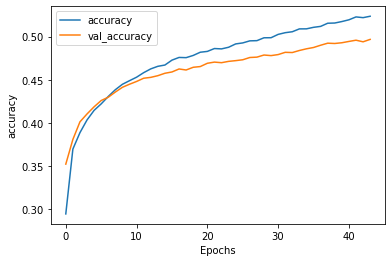

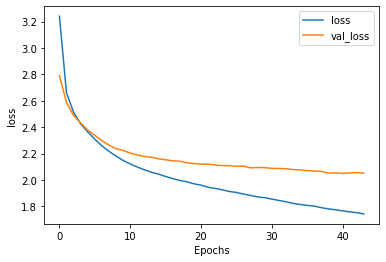

In [39]:
def show(history):
    #Show the result of the training
    def plot_graphs(history, string):
        plt.plot(history.history[string])
        plt.plot(history.history['val_'+string])
        plt.xlabel("Epochs")
        plt.ylabel(string)
        plt.legend([string, 'val_'+string])
        plt.show()
    
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")
    
show(history)

In [40]:
#Teszteljük a modelt
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

462/462 [==============================] - 1s 1ms/step - loss: 2.0274 - accuracy: 0.4974
Accuracy 0.4974275529384613


Eredmények

SVM pontossága: 0.25

Az SVM nem skálázódik jól az adatmennyiség növekedtével

Decision Tree pontossága: 0.41

Érzékeny a zajos adatokra

KNN pontossága: 0.41

A KNN nem skálázódik jól az adatok dimenziójának növekedtével

DNN pontossága: 0.5

A DNN legjobban teljesít, ha az adatmennyiség nagy